In [1]:
%pylab inline

import sys
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

import seaborn
from scipy.stats import sem
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.manifold import TSNE, Isomap
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabaz_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.cluster import AgglomerativeClustering

from lib import ExRF

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
# generate synthetic dataset
x, y = make_classification(n_samples=1000, n_classes=8, n_features=50, n_informative=3,n_redundant=0, n_clusters_per_class=1, class_sep=2, random_state=42)

# mask for binary classification
y_bin = y < 3

# preprocessing
x = StandardScaler().fit_transform(x)

In [3]:
# fit a random forest to distinguish between the two class supersets 
model = ExRF(n_estimators=100, oob_score = True, random_state=42)
model.fit(x,y_bin)
model.model.oob_score_

0.97

In [4]:
# use shap to get instance level explanations
# limit to 500 subset for speed
x=x[y_bin][:500]
y=y[y_bin][:500]
e=model.explain_shap(x)

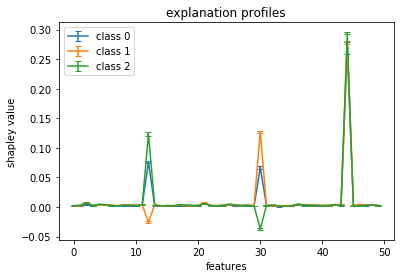

In [5]:
errorbar(x=range(len(x[0])),y=mean(e[y==0],0), yerr=sem(e[y==0],0), capsize=3, label='class 0')
errorbar(x=range(len(x[0])),y=mean(e[y==1],0), yerr=sem(e[y==1],0), capsize=3, label='class 1')
errorbar(x=range(len(x[0])),y=mean(e[y==2],0), yerr=sem(e[y==2],0), capsize=3, label='class 2')
title ('explanation profiles')
xlabel('features')
ylabel('shapley value')
legend()

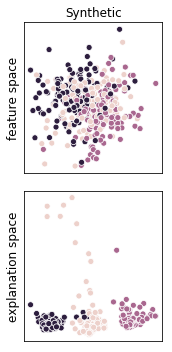

In [6]:
figure(figsize=(2.5,5))

subplot(211)
p = PCA(whiten=True).fit_transform(x)
seaborn.scatterplot(p.T[0], p.T[1], hue=y, legend=False)
title('Synthetic')
ylabel('feature space', fontdict={'size':12})
xticks([])
yticks([])

subplot(212)
p = PCA(whiten=True).fit_transform(e)
seaborn.scatterplot(p.T[0], p.T[1], hue=y, legend=False)
ylabel('explanation space', fontdict={'size':12})
xticks([])
yticks([])

tight_layout()


In [13]:
xi, yi, ei = x,y,e

class Identity:
    def __init__(self, n):pass
    def fit_transform(self, x):
        return x

for t in [Identity, PCA, Isomap, TSNE]:

    print('\n\n\n')
    print (t.__name__)
    
    pei=t(2).fit_transform(ei)
    pxi=t(2).fit_transform(xi)

    for metric in [davies_bouldin_score, silhouette_score, calinski_harabaz_score]:
        me=metric(pei,yi)
        mx=metric(pxi,yi)

        print(metric.__name__)
        print('fx = ', mx)
        print('fe = ', me)
        print('fe/fx = ', (me-mx)/(me+mx))
        print()

    y_=AgglomerativeClustering(3).fit_predict(pei)
    ae=adjusted_mutual_info_score(yi, y_)

    y_=AgglomerativeClustering(3).fit_predict(pxi)
    ax=adjusted_mutual_info_score(yi, y_)

    print(ae, ax)





Identity
davies_bouldin_score
fx =  6.995599300599294
fe =  1.1052985281491883
fe/fx =  -0.7271170303551532

silhouette_score
fx =  0.015801853686015156
fe =  0.46385157786182374
fe/fx =  0.9341113702240275

calinski_harabaz_score
fx =  6.517520806779947
fe =  192.61677348182516
fe/fx =  0.9345414527410923

0.5854111010195566 0.08283188652099054




PCA
davies_bouldin_score
fx =  3.3076527642661318
fe =  0.778215375667485
fe/fx =  -0.6190697550606082

silhouette_score
fx =  0.012151056609373498
fe =  0.6554454544334171
fe/fx =  0.963597603018046

calinski_harabaz_score
fx =  38.07529727906392
fe =  258.23539225774596
fe/fx =  0.743004227497949

0.5854111010195566 0.1397841693520894




Isomap
davies_bouldin_score
fx =  12.903073563897445
fe =  0.718644895743913
fe/fx =  -0.8944854281237533

silhouette_score
fx =  -0.02497405139850286
fe =  0.715388035778645
fe/fx =  1.0723451493263847

calinski_harabaz_score
fx =  3.9258236698135662
fe =  187.73143432719888
fe/fx =  0.9590328724219